<a href="https://colab.research.google.com/github/UPstartDeveloper/DS-2.1-Machine-Learning/blob/master/Notebooks/Cereal_Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suppose you have the following [dataset](https://docs.google.com/spreadsheets/d/1OyFwsZ77RnGiwSSkTPx6j9V9qyOqitysQij4WW4nhMU/edit#gid=1943041330)*, which is a list of 80 cereals, containing the following fields:

`mfr`: Manufacturer of cereal                   
- A = American Home Food Products
- G = General Mills
- K = Kelloggs                
- N = Nabisco               
- P = Post               
- Q = Quaker Oats              
- R = Ralston Purina  
         
`type`:              
- cold               
- hot 

`calories`: calories per serving      
`protein`: grams of protein per serving          
`fat`: grams of fat per serving           
`sodium`: milligrams of sodium           
`fiber`: grams of dietary fiber           
`carbs`: grams of complex carbohydrates           
`sugars`: grams of sugars           
`potass`: milligrams of potassium           
`vitamins`: vitamins and minerals - 0, 25, or 100, indicating the typical percentage of FDA recommended            
`shelf`: display shelf (1, 2, or 3, counting from the floor)           
`weight`: weight in ounces of one serving           
`cups`: number of cups in one serving           
`rating`: a rating of the cereals (Possibly from Consumer Reports?)   
    
Given the above, can you build a model using Python to predict cereal rating? We'll be creating a multivariate linear regression as a solution for premium users.

# Scikit-Learn Solution

## Step 1: Imports

In [1]:
# Machine Learning
import sklearn
from sklearn.model_selection import train_test_split
# Data Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Data Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

## Step 2: Get the Data

In [2]:
# you can use the address below to access the dataset from my GitHub repo
URL = "https://raw.githubusercontent.com/UPstartDeveloper/DS-1.1-Data-Analysis/master/Notebooks/Datasets/cereal.csv"
df = pd.read_csv(URL)
# verify it came through ok
df.head(10)

,name,mfr,type,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.0,5.0,6,280,25,3,1.00,0.33,68.402973
1,100% Natural Bran,Q,C,120,3,5,15,2.0,8.0,8,135,0,3,1.00,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5,320,25,3,1.00,0.33,59.425505
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.0,8.0,0,330,25,3,1.00,0.50,93.704912
4,Almond Delight,R,C,110,2,2,200,1.0,14.0,8,-1,25,3,1.00,0.75,34.384843
5,Apple Cinnamon Cheerios,G,C,110,2,2,180,1.5,10.5,10,70,25,1,1.00,0.75,29.509541
6,Apple Jacks,K,C,110,2,0,125,1.0,11.0,14,30,25,2,1.00,1.00,33.174094
7,Basic 4,G,C,130,3,2,210,2.0,18.0,8,100,25,3,1.33,0.75,37.038562
8,Bran Chex,R,C,90,2,1,200,4.0,15.0,6,125,25,1,1.00,0.67,49.120253
9,Bran Flakes,P,C,90,3,0,210,5.0,13.0,5,190,25,3,1.00,0.67,53.313813


## Step 3: Data Analysis


TODO: remove outliers in numerical columns like `potass`, `vitamins`, etc.

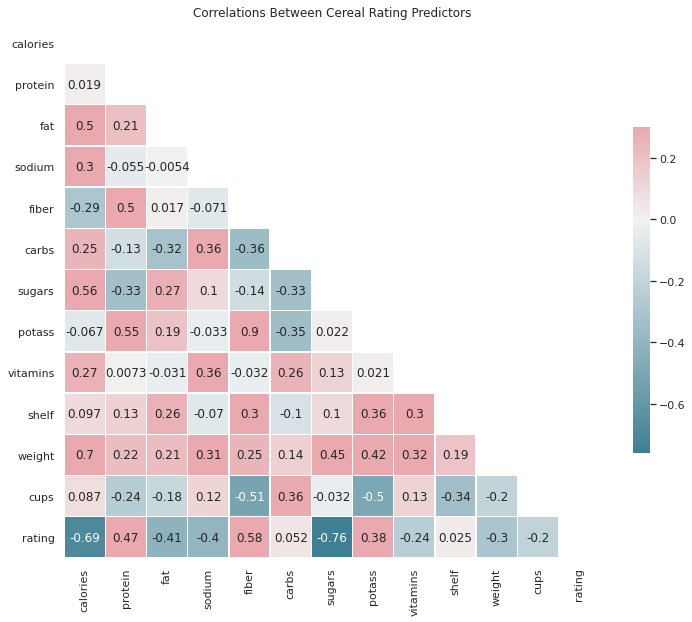

In [3]:
def make_heatmap(df, map_title):
    """Plots the diagonal correlation matrix of a dataset using Seaborn.

       Credit to the Seaborn Documentation for inspiring this cell:
       https://seaborn.pydata.org/examples/many_pairwise_correlations.html
       
       Args:
       df(pandas.DataFrame): encapsulates the dataset being used to make heatmap.
       map_title(str): the title for the heatmap
    
    """
    sns.set(style="white")
    # Compute the correlation matrix
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 12))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
    plt.title(map_title)
    plt.show()

make_heatmap(df, "Correlations Between Cereal Rating Predictors")

Based on the heatmap above, I argue we ought to leave the following variables out of the model:
1. `weight`: because it appears to correlate positively with just about every other variable
2. `shelf`: this would be irrelevant to what rating a cereal gets in real life, based on how rarely I'd say you hear people talk about it in actual cereal reviews.
3. `cups`: similar reason to the `shelf` column, I'd argue this column is contextually irrelevant to the reason a cereal gets a certain rating and not another.

My intuition tells my the `type` column is only one value - let's verify!

In [4]:
cereal_types = df["type"]
print(f"The 'type' column has {cereal_types.nunique()} unique values.")

The 'type' column has 2 unique values.


Ok so I was wrong, let's take a look at the distribution of these values:

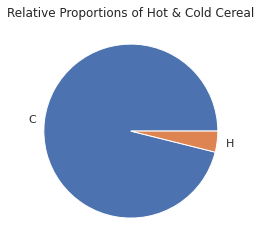

In [5]:
plt.pie(cereal_types.value_counts(), labels=cereal_types.unique())
plt.title("Relative Proportions of Hot & Cold Cereal")
plt.show()

So now we know the overwhelming majority of cereals in the dataset are cold.

Let's also see the relative proportions of the 4 manufacturers represented in the dataset:


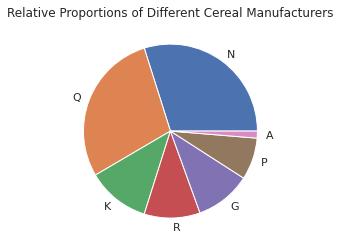

In [6]:
plt.pie(df["mfr"].value_counts(), labels=df["mfr"].unique())
plt.title("Relative Proportions of Different Cereal Manufacturers")
plt.show()

To be honest, I considered leaving this column out of the model because I personally don't think manufacturers should predict with cereal rating. However, since the cereal manufacturing market usually doesn't get disrupted very often, I'll leave it in as it could be possible that name brand influences how cereals are rated.

## Step 4: Data Preprocessing
- encode categorical variables 

In [7]:
# encode the categorical variables
mfrs_encoded = pd.get_dummies(df["mfr"], prefix="mfr")
# replace the manufacturer columns w/ one-hot-encoded columns
for col in mfrs_encoded.columns:
  df[col] = mfrs_encoded[col]
# encode the "type" columns as well - binary values
encoder = OneHotEncoder(sparse=False)
types = np.array(df["type"]).reshape(-1, 1)
df["type"] = encoder.fit_transform(types)
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbs,sugars,potass,vitamins,shelf,weight,cups,rating,mfr_A,mfr_G,mfr_K,mfr_N,mfr_P,mfr_Q,mfr_R
0,100% Bran,N,1.0,70,4,1,130,10.0,5.0,6,280,25,3,1.0,0.33,68.402973,0,0,0,1,0,0,0
1,100% Natural Bran,Q,1.0,120,3,5,15,2.0,8.0,8,135,0,3,1.0,1.00,33.983679,0,0,0,0,0,1,0
2,All-Bran,K,1.0,70,4,1,260,9.0,7.0,5,320,25,3,1.0,0.33,59.425505,0,0,1,0,0,0,0
3,All-Bran with Extra Fiber,K,1.0,50,4,0,140,14.0,8.0,0,330,25,3,1.0,0.50,93.704912,0,0,1,0,0,0,0
4,Almond Delight,R,1.0,110,2,2,200,1.0,14.0,8,-1,25,3,1.0,0.75,34.384843,0,0,0,0,0,0,1


- feature selection

In [8]:
# drop all unnecessary cols
df = df.drop(["name", "mfr", "shelf", "weight", "cups"], axis=1)
# separate predictors from target
X, y = (
    df[[col for col in df.columns if not col == "rating"]],
    df["rating"]
)

- standardizing the values to a Gaussian distribution

In [9]:
# standardize values
scaler = sklearn.preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

We could also perform PCA, but we'll come back to this later after seeing the results with merely scaling the selected features.

## Step 5: Split the Data
Here we will use 75% of the examples for training, and the remaining 25% for testing.

In [10]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                                  train_size=0.75, 
                                                                  test_size=0.25)

## Step 6: Fit the Linear Regression Model on Training Data

In [11]:
from sklearn import linear_model

# instantiate the regressor
model = linear_model.LinearRegression()
# train the regressor
model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Step 7: Evaluate the Model on Validation Data
- visualize the disparity between the model's predictions and the actual ratings

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


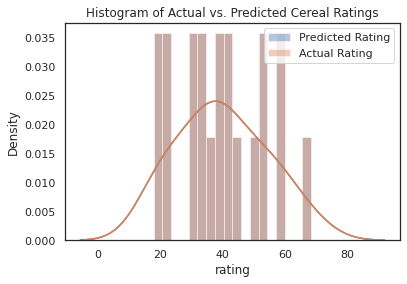

In [12]:
def prediction_vs_actual(model, X_test, y_test):  
    """Overlay the distributions of predicted vs. actual ratings."""
    # predict ratings w/ the model 
    y_pred = model.predict(X_test)
    # make PDFs of the predictions and the actual ratings
    sns.distplot(y_pred, hist=True, kde=True, bins=18, label='Predicted Rating')
    sns.distplot(y_test, hist=True, kde=True, bins=18, label='Actual Rating')
    # make the plot readable
    plt.legend()
    plt.title('Histogram of Actual vs. Predicted Cereal Ratings')
    plt.show()
    return y_pred

y_pred = prediction_vs_actual(model, X_test_scaled, y_test)

What? The distributions perfectly overlay one another?

Let's now inspect the MSE of this model, to take a look at this analytically:

In [13]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

1.1770029505037335e-13

In [14]:
# just another look, we'll also compute the R^2 score
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)  # Value 0-1, with 1 being the best (yet possibly overfitted) value

0.9999999999999993

## Step 8: Validation and Conclusion

### Conclusion
Based on the graph, MSE, and R^2 metrics suggest that the model is overfit on the data.

One reason why this might be occurring is that I gave too many input features to the model.

To go forward with regularizing this model, we can try the following:
- *Feature Selection*: I could print out the weights of the model for each predictor currently (using `model.coef_`), and then retrain the model with only the columns with the most weights (still keeping in mind the correlation heatmap above, so we don't select highly correlated features). 
- *Feature Compression*: I could use Principal Component Analysis (aka "PCA") to reduce the dimensions of the data used to train the model to just 2 or 3 features.
- *More Data Cleaning*: Additionally, I could also remove some rows in the dataset if they contain outlier values.

- **TODO**: do 5-fold cross validation, once we have gotten the model to regularize based on feature selection or PCA (as outlined above)